In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 4

# 入力長

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [10]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2024-12-15 18:07:58.834619: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/32 [..............................] - ETA: 6s - loss: 1.3839 - accuracy: 0.2031
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 4ms/step - loss: 1.3759 - accuracy: 0.4300 - val_loss: 1.3651 - val_accuracy: 0.5680
Epoch 2/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3772 - accuracy: 0.3984
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 1ms/step - loss: 1.3565 - accuracy: 0.3950 - val_loss: 1.3455 - val_accuracy: 0.5808
Epoch 3/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3343 - accuracy: 0.5859
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 2ms/step - loss: 1.3345 - accuracy: 0.5300 - val_loss: 1.3211 - val_accuracy: 0.5989
Epoch 4/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3078 - a

In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 43ms/step
[0.9421684  0.02060822 0.01585691 0.02136642]
0


# 混同行列

42/42 [==============================] - 0s 264us/step


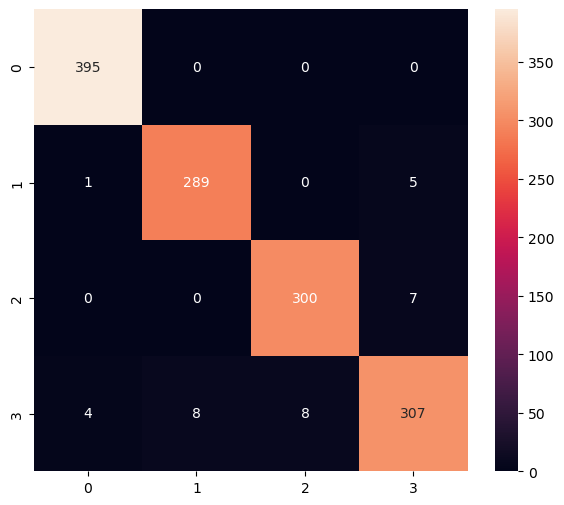

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.97      0.98      0.98       295
           2       0.97      0.98      0.98       307
           3       0.96      0.94      0.95       327

    accuracy                           0.98      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.97      0.98      0.97      1324



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [17]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [18]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmp9o12oecp/assets


2024-12-15 18:08:11.746775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-15 18:08:11.746789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-12-15 18:08:11.746919: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmp9o12oecp
2024-12-15 18:08:11.747534: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-12-15 18:08:11.747539: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmp9o12oecp
2024-12-15 18:08:11.749079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-12-15 18:08:11.749527: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-12-15 18:08:11.760060: I tensorflow/cc/saved_model/loader.

6432

# 推論テスト

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [20]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 81 μs, sys: 26 μs, total: 107 μs
Wall time: 93 μs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9421684  0.02060823 0.01585691 0.02136643]
0
